In [1]:
import matplotlib
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal, interpolate, fftpack

COLORS = ['blue', 'red', 'green', 'purple', 'gold', 'brown']

# Load CSV data 

In [2]:
alice_df = pd.read_csv('Alice.csv')

# The last row contains footer, delete it
alice_df.drop(alice_df.tail(1).index, inplace=True)

# show information about "alice_df"
alice_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4742 entries, 0 to 4741
Data columns (total 8 columns):
Axis1        4742 non-null object
Axis2        4742 non-null object
Axis3        4742 non-null object
Axis4        4742 non-null object
Axis5        4742 non-null object
Axis6        4742 non-null object
Label        4742 non-null object
Timestamp    4742 non-null object
dtypes: object(8)
memory usage: 333.4+ KB


In [3]:
alice_df.head(15)

,Axis1,Axis2,Axis3,Axis4,Axis5,Axis6,Label,Timestamp
0,0.112549,0.181885,0.857666,0.687023,0.610687,-0.778626,3,1445474432.892972
1,0.111816,0.182373,0.864014,0.549618,3.832061,4.916030,3,1445474433.341528
2,0.110596,0.180908,0.859131,3.893130,-1.740458,5.068702,3,1445474433.401195
3,0.113281,0.179932,0.852051,0.122137,4.030534,5.358778,3,1445474433.431016
4,0.110107,0.181885,0.854736,0.473282,-5.648855,-3.374046,3,1445474433.490600
5,0.113037,0.181641,0.856201,-5.450382,0.610687,5.618320,3,1445474433.494716
6,0.112061,0.183594,0.854980,-0.259542,-0.748092,9.633588,3,1445474433.521230
7,0.113770,0.181396,0.863770,1.007634,0.122137,0.625954,3,1445474433.551036
8,0.111084,0.176514,0.851318,-1.114504,-0.381679,7.312977,3,1445474433.581342
9,0.113281,0.182373,0.859131,2.442748,5.297710,-7.282443,3,1445474433.670688


##  Give column appropriate datatype

In [4]:
for axis_idx in range(1, 6 + 1):
    axis_name = 'Axis' + str(axis_idx)
    alice_df[axis_name] = alice_df[axis_name].astype(np.float64)
alice_df['Label'] = alice_df['Label'].astype(np.uint8)
alice_df['Timestamp'] = alice_df['Timestamp'].astype(np.float64)

# show information about "alice_df"
alice_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4742 entries, 0 to 4741
Data columns (total 8 columns):
Axis1        4742 non-null float64
Axis2        4742 non-null float64
Axis3        4742 non-null float64
Axis4        4742 non-null float64
Axis5        4742 non-null float64
Axis6        4742 non-null float64
Label        4742 non-null uint8
Timestamp    4742 non-null float64
dtypes: float64(7), uint8(1)
memory usage: 301.0 KB


In [5]:
def zero_start(x, adjust):
    return x - adjust

# convert timestamp (sec) into time flow starting from 0
start_timestamp = float(alice_df['Timestamp'][0])
alice_df['Timestamp_extra'] = alice_df['Timestamp'].apply(zero_start, args=(start_timestamp,))
alice_df.drop(['Timestamp'], axis=1, inplace=True)
alice_df.rename(columns={'Timestamp_extra': 'Timestamp'}, inplace=True)
alice_df.tail(15)

,Axis1,Axis2,Axis3,Axis4,Axis5,Axis6,Label,Timestamp
4727,0.081299,0.189453,0.861572,-0.748092,2.763359,-2.870229,3,152.167013
4728,0.083984,0.193359,0.857422,1.832061,-1.832061,-4.503817,3,152.197031
4729,0.082031,0.191406,0.863770,1.557252,0.809160,3.832061,3,152.227031
4730,0.078857,0.193604,0.857666,0.000000,4.137404,31.083969,3,152.257037
4731,0.084229,0.192139,0.865967,-2.625954,0.809160,3.709924,3,152.287321
4732,0.076172,0.190918,0.868408,0.290076,30.641222,30.977098,3,152.316952
4733,0.083008,0.192871,0.860596,-2.656489,10.885496,-0.167939,3,152.347504
4734,0.080566,0.196533,0.865723,1.587786,3.541985,3.709924,3,152.377033
4735,0.078857,0.191650,0.858643,0.167939,-4.473282,-4.274809,3,152.407074
4736,0.079834,0.196045,0.852539,-1.404580,-0.473282,-5.374046,3,152.436968


As you can see, the data records about **152.587 seconds**.

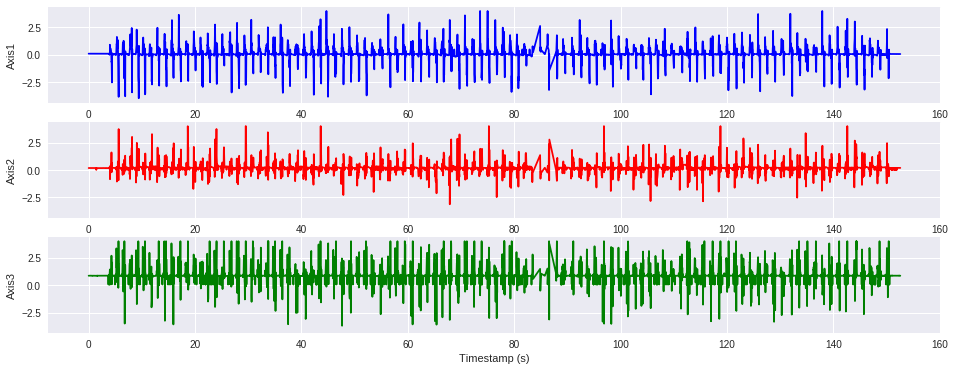

In [7]:
f, ax = plt.subplots(3, 1, figsize=(16, 6), sharey='all')

ts = alice_df['Timestamp'].values
for axis_idx in range(3):
    axis_name = 'Axis' + str(axis_idx + 1)
    ax[axis_idx].plot(ts, alice_df[axis_name].values, color=COLORS[axis_idx])
    ax[axis_idx].set_ylabel(axis_name)
plt.xlabel('Timestamp (s)')
plt.show()

In [9]:
[plt.plot(ts_orig, axis[i]) for i in range(6) ]
plt.show()

NameError: name 'ts_orig' is not defined

In [31]:
fs = 300
ps = 1/fs
n = np.int16(8192)
freq = np.linspace(0, fs/2, num=int(n//2))
ts_new =  np.arange(min(ts_orig), max(ts_orig), ps)
axis_interpolant = [interpolate.interp1d(ts_orig, axis[i]) for i in range(6) ]
axis_new = [axis_interpolant[i](ts_new) for i in range(6) ]


In [46]:
axis_new

[array([ 0.03051758,  0.03050883,  0.03050008, ..., -0.01435854,
        -0.01491803, -0.01547752]),
 array([-0.93896484, -0.93924486, -0.93952488, ..., -0.99664306,
        -0.99643961, -0.99623616]),
 array([ 0.25341797,  0.25334796,  0.25327796, ...,  0.06607051,
         0.06474808,  0.06342566]),
 array([-1.81679389, -1.81679389, -1.81679389, ..., -0.26717468,
        -0.24172944, -0.21628419]),
 array([-0.33587786, -0.33314181, -0.33040575, ...,  0.4121994 ,
         0.00507555, -0.40204831]),
 array([-0.54961832, -0.46206456, -0.37451081, ..., -1.76338118,
        -2.3995122 , -3.03564323])]

[[<matplotlib.lines.Line2D at 0x7f806b8b42b0>],

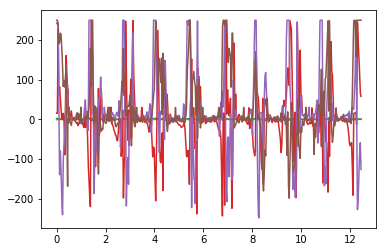

In [13]:
[plt.plot(ts_new, axis_new[i]) for i in range(6) ]


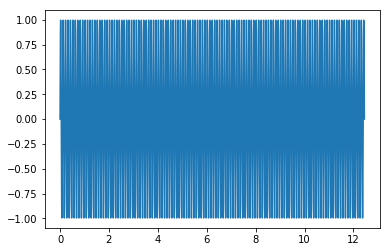

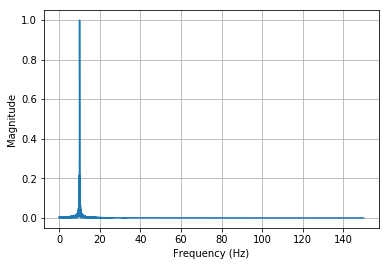

In [14]:
signal0 = np.sin(2*np.pi*10*ts_new)
plt.plot(ts_new, signal0)
spectrum = 2*fftpack.fft(signal0, n=n)/len(signal0)
plt.figure()
plt.plot(freq, np.abs(spectrum[0:n//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()

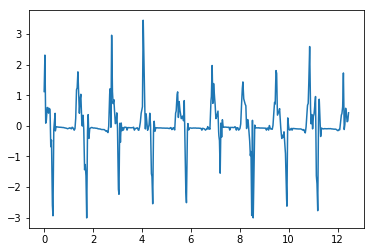

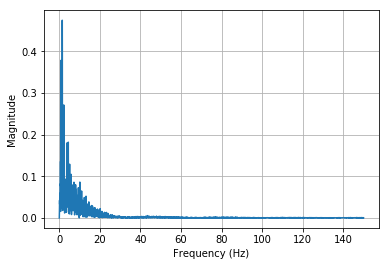

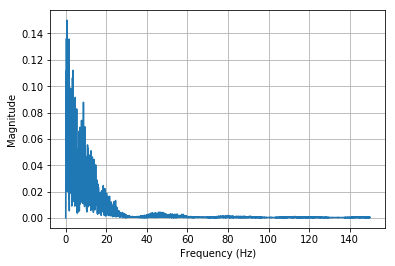

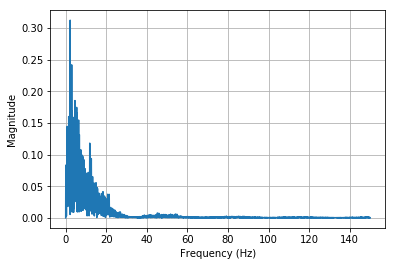

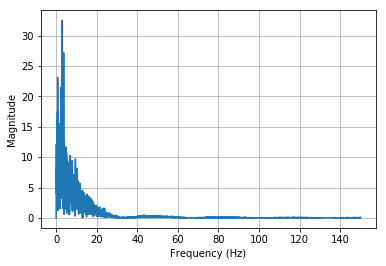

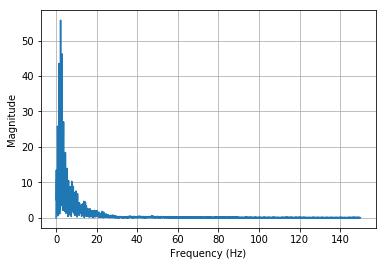

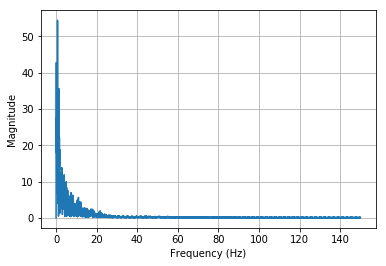

In [15]:
axis_new = [axis_new[i] - np.mean(axis_new[i]) for i in range(6)]
spectrum = [2*fftpack.fft(axis_new[i], n=n)/len(axis_new[i]) for i in range(6)]
freq = np.linspace(0, fs/2, num=int(n/2))
plt.figure()
plt.plot(ts_new, axis_new[0])
for i in range(6):
    plt.figure()
    plt.plot(freq, np.abs(spectrum[i][0:n//2])) 
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()

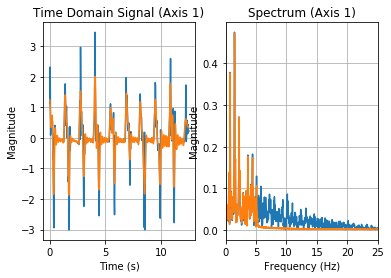

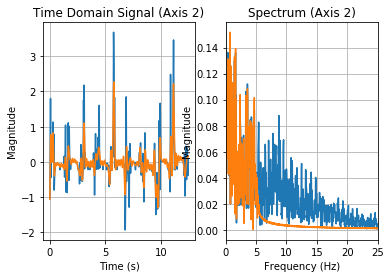

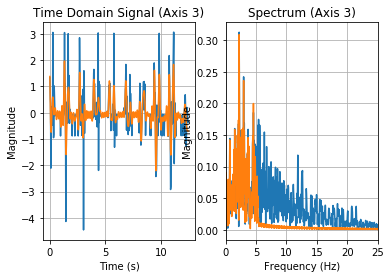

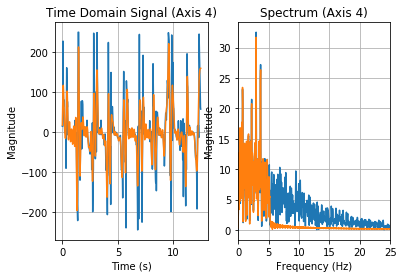

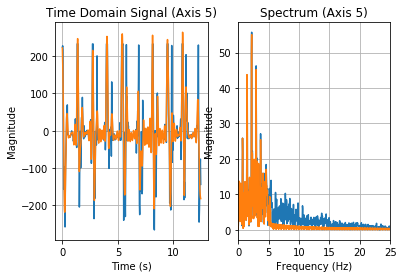

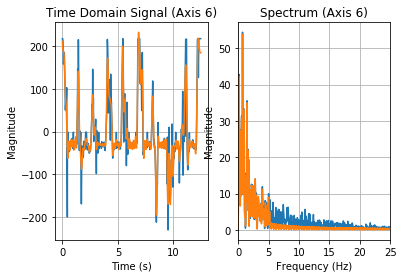

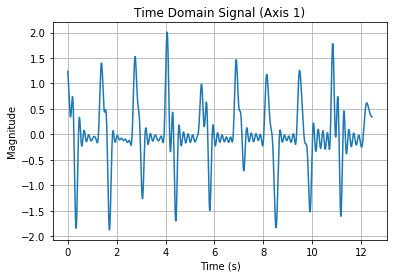

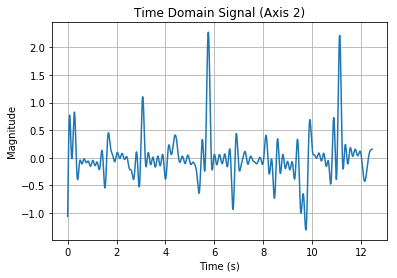

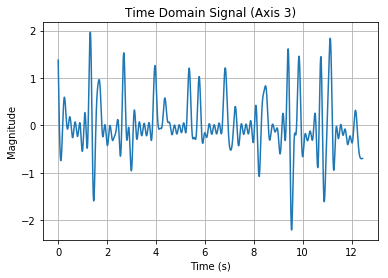

In [17]:
corner_freq = 5
b, a = signal.ellip(10, 0.01, 100, 2*corner_freq/fs)
#s_lpf = signal.lfilter(b, a, s)
#axis_lpf = [signal.lfilter(b, a, axis_new[i]) for i in range(6)]
axis_lpf = [signal.filtfilt(b, a, axis_new[i]) for i in range(6)]

for i in range(6):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(ts_new, axis_new[i])
    plt.plot(ts_new, axis_lpf[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Magnitude')
    plt.title('Time Domain Signal (Axis ' +str(i+1) + ')')
    plt.grid()
    
    spectrum_orig = fftpack.fft(axis_new[i], n=n)/len(axis_new[i])
    spectrum_orig_ss = spectrum_orig[0:n//2]
    spectrum_orig_ss[2:] = 2*spectrum_orig_ss[2:]
    freq = np.linspace(0, fs/2, num=int(n//2))
    plt.subplot(1, 2, 2)
    plt.plot(freq, np.abs(spectrum_orig[0:n//2]))                
    spectrum = fftpack.fft(axis_lpf[i], n=n)/len(axis_lpf[i])
    spectrum_ss = spectrum[0:n//2]
    spectrum_ss[2:] = 2*spectrum_ss[2:]
    freq = np.linspace(0, fs/2, num=int(n//2))
    plt.plot(freq, np.abs(spectrum[0:n//2])) 
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Spectrum (Axis ' +str(i+1) + ')')
    plt.xlim([0, corner_freq+20])
    plt.grid()
    
for i in [0, 1, 2]:
    plt.figure()    
    plt.plot(ts_new, axis_lpf[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Magnitude')
    plt.title('Time Domain Signal (Axis ' +str(i+1) + ')')
    plt.grid()